### This notebook is experimental (fancier word for dirty) and unfinished.

## Data Exploration of Josef's Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In /home/spaceape/anaconda3/envs/graphs/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/spaceape/anaconda3/envs/graphs/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/spaceape/anaconda3/envs/graphs/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
pages_id_pos = [i.strip() for i in open('../data/split_positive_uniq.csv').readlines()]
pages_id_neg = [i.strip() for i in open('../data/split_negative_uniq.csv').readlines()]

df1 = pd.read_csv('../data/d1.csv',
                 sep=',')
df2 = pd.read_csv('../data/d2.csv',
                 sep=',')
df3 = pd.read_csv('../data/d3.csv',
                 sep=',')

print(len(df1), len(df2), len(df3))

10000 10000 10000


In [4]:
df = pd.concat([df1, df2, df3], ignore_index=True)
del df1, df2, df3

In [5]:
# conversion of page name into id I used
name2id = {r['Page Name']: r['URL'].split('/')[3] for i, r in df.iterrows()}
id2name = {r['URL'].split('/')[3]: r['Page Name'] for i, r in df.iterrows()}

In [8]:
# SAVE FILE
# with open('../data/id2name.json', 'w') as fw:
#     json.dump(id2name, fw)

In [5]:
df.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Likes at Posting',
       'Followers at Posting', 'Created', 'Type', 'Likes', 'Comments',
       'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care',
       'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x )'],
      dtype='object')

In [6]:
df['Page Name'].value_counts()

Environmental Coffeehouse         1145
Climate State                      717
Friends of Science                 681
Global Warming Fact of the Day     606
Skeptical Science                  582
                                  ... 
Cranky Uncles                        1
Fridays For Future USA               1
Effect Of Climate Change             1
US Climate and Health Alliance       1
Global Warming Solved                1
Name: Page Name, Length: 239, dtype: int64

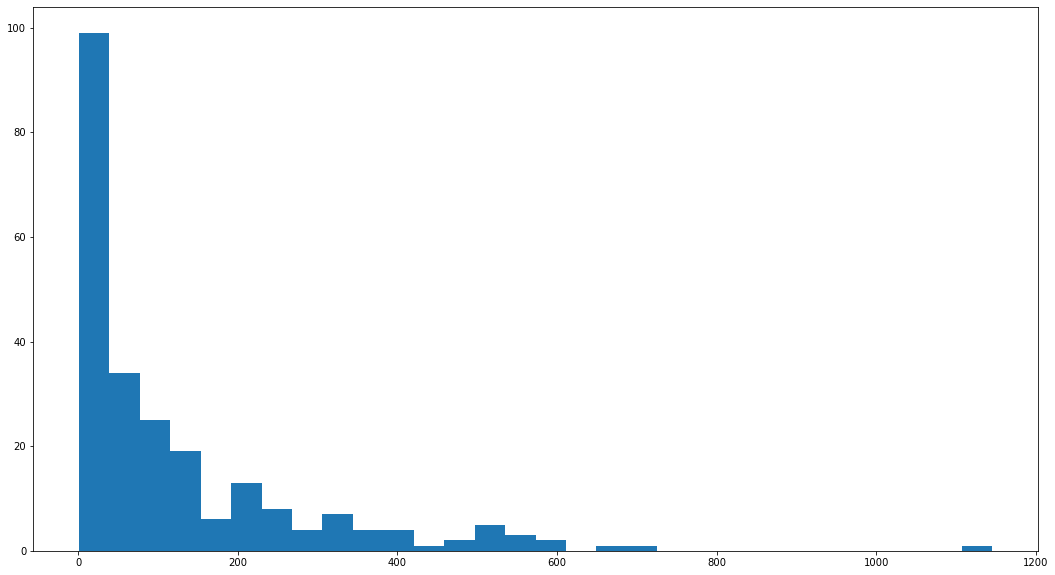

In [7]:
plt.figure(figsize=(18,10))
plt.hist(df['Page Name'].value_counts(), 30)
plt.show()

## NLP

In [8]:
import spacy
from spacy_langdetect import LanguageDetector
from tqdm.notebook import tqdm
import numpy as np

In [9]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

### Test

In [10]:
a = "This is first try!"
b = "Some people think, they know everything, though they know nothing."
c = "This is first try! Some people think, they know everything, though they know nothing."

In [11]:
A = (nlp(a).vector + nlp(b).vector) / 2
B = nlp(c).vector

In [12]:
A[:10]

array([-0.05550019,  0.2840991 , -0.17949313, -0.11737775,  0.02935907,
        0.02835431, -0.01165269, -0.1501201 , -0.01944216,  2.4167354 ],
      dtype=float32)

In [13]:
B[:10]

array([-0.06775057,  0.28027713, -0.22383945, -0.16029002,  0.02768043,
        0.08652005, -0.00715419, -0.14439213, -0.05170711,  2.512422  ],
      dtype=float32)

In [14]:
nlp(a)._.language

{'language': 'en', 'score': 0.9999978022275227}

### Prepare fb-page vector embeddings

In [117]:
# nlp.max_length = 2000000

In [119]:
uniq_pages = list(df['Page Name'].unique())
print(f"Number of unique pages: {len(uniq_pages)}")

Number of unique pages: 239


In [120]:
def generate_page_vecs(df, nlp, merge_all_posts_first=False):
    uniq_pages = list(df['Page Name'].unique())
    page_vecs = {}
    if not merge_all_posts_first:
        for page in tqdm(uniq_pages):
            vec = []
            for i, post in df.loc[df['Page Name'] == page].iterrows():
                # preprocessing, removing stop words in here post[col]
                text = " ".join([post[col] 
                                  for col in ['Message', 'Image Text', 'Link Text', 'Description']
                                  if isinstance(post[col], str) ])
                vec.append(nlp(text).vector)
            page_vecs[page] = sum(vec) / len(vec)

    else:
        for page in tqdm(uniq_pages):
            vec = []
            for i, post in df.loc[df['Page Name'] == page].iterrows():
                # preprocessing, removing stop words in here post[col]
                text = " ".join([post[col] 
                                  for col in ['Message', 'Image Text', 'Link Text', 'Description']
                                  if isinstance(post[col], str) ])
                vec.append(text)
            page_vecs[page] = nlp(" ".join(vec)).vector
    return page_vecs


def generate_post_vecs(df, nlp, merge_all_posts_first=False):
    uniq_pages = list(df['Page Name'].unique())
    post_vecs = []
    for i, post in tqdm(df.iterrows()):
        # preprocessing, removing stop words in here post[col]
        text = " ".join([post[col] 
                          for col in ['Message', 'Image Text', 'Link Text', 'Description']
                          if isinstance(post[col], str) ])
        post_vecs.append(nlp(text).vector)
    return post_vecs

In [121]:
page_vecs = generate_page_vecs(df[['Page Name', 'Message', 'Image Text', 'Link Text', 'Description']], 
                               nlp,
                              False)

MemoryError: Unable to allocate 6.46 GiB for an array with shape (333303, 5200) and data type float32

In [83]:
post_vecs = generate_post_vecs(df[['Page Name', 'Message', 'Image Text', 'Link Text', 'Description']], nlp)

In [18]:
vecs = np.zeros((len(page_vecs), 300))
for i, p in enumerate(page_vecs):
    vecs[i] = page_vecs[p]

In [86]:
vecs = np.zeros((len(post_vecs), 300))
for i, _ in enumerate(post_vecs):
    vecs[i] = post_vecs[i]

## Dimensionality Reduction

In [89]:
from sklearn.decomposition import PCA

In [90]:
pca10 = PCA(n_components=10)
vecs_pca10 = pca10.fit_transform(vecs)

pca2 = PCA(n_components=2)
vecs_pca2 = pca2.fit_transform(vecs)

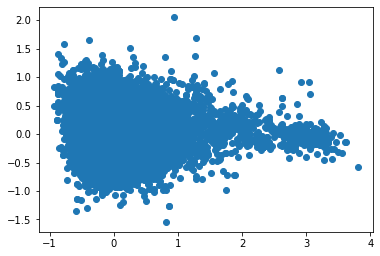

In [91]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(vecs_pca2[:, 0], vecs_pca2[:, 1]) 
plt.show()

## Unsupervised

### K-means

In [92]:
from sklearn.cluster import KMeans

In [93]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vecs)

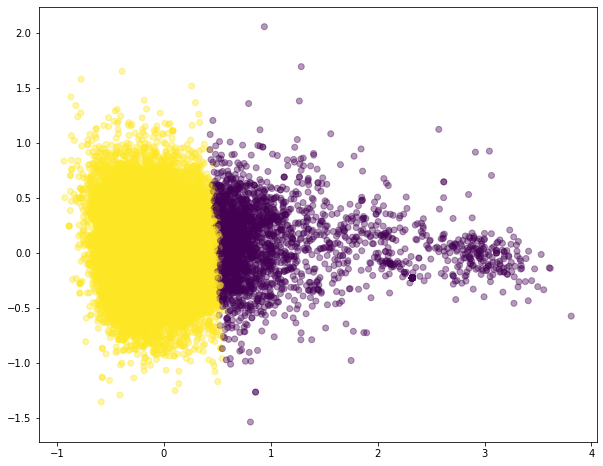

In [103]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vecs_pca2[:,0], vecs_pca2[:,1], c=kmeans.labels_, alpha=.4)
plt.show()

### T-SNE

In [105]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
tsne = TSNE(random_state=11, n_iter=1000, metric="cosine")
embed_tsne = tsne.fit_transform(vecs)

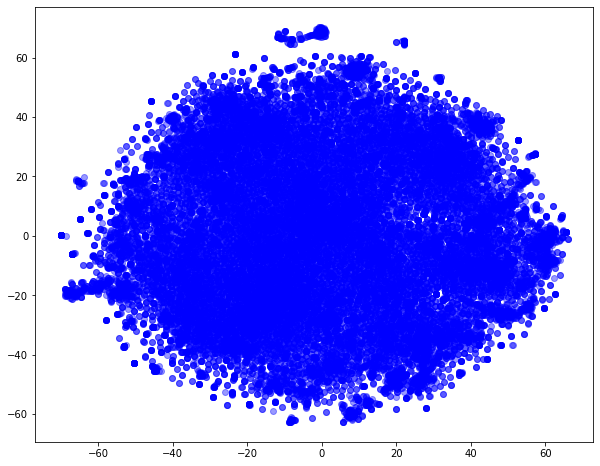

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(embed_tsne[:,0], embed_tsne[:,1], alpha=.4, color='blue')
plt.show()

### Spectral Clustering

In [109]:
from sklearn.cluster import SpectralClustering

In [110]:
sc_labels = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit_predict(vecs)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vecs_pca2[:,0], vecs_pca2[:,1], c=sc_labels, alpha=.4)
plt.show()

### OPTICS

In [111]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=2).fit(vecs)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(vecs_pca2[:,0], vecs_pca2[:,1], c=optics.labels_, alpha=.4)
plt.show()

## Supervised?

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# 'greenpeace.international',
pos = ['NASAClimateChange',
       'acespace', 'greenpeace.international',
       'ClimateChangeIsReal', 'climatereality',
       'ClimateChangeNews', 'NatureClimateChange',
       'ClimateChangeCauses', 'GlobalwarmingEva']

# 'ClimateChangeIsNatural'
neg = ['cfact',
       'iloveco2', 'ClimateChangeLIES',
       'australianclimatemadness', 'ClimateDepot',
       'ccdispatch', 'TheCO2Coalition',
       'Global-Warming-Climate-Change-whatever-its-called-is-a-scam-241741379521',
       'Global-Climate-Scam-1392664020945768']

In [29]:
pos_names = [id2name[i] for i in pos if i in id2name]
neg_names = [id2name[i] for i in neg if i in id2name]
print(f"pos: {len(pos_names)}\tneg: {len(neg_names)}")

pos: 6	neg: 7


In [37]:
# Pages I could not matched with the id
[(k, name2id[k]) for k, v in page_vecs.items() if name2id[k] not in pages_id_pos and name2id[k] not in pages_id_neg]

[('Water Pollution Forum', '122361961141543'),
 ('Pennsylvania Coalition for Responsible Government', '136241923085699'),
 ('Greta Thunberg Memes', '100304111377683'),
 ('Steven Haywood Yaskell', '407976212610290'),
 ('Halt! Copenhagen until CLIMATE-GATE has been fully INVESTIGATED.',
  '336459475181'),
 ('Save The World From Effects Of Global Warming', '398539503832141'),
 ('wattsupwiththat', '133662869999306'),
 ('Education for Sustainable Development / Education au Développement Durable',
  '115988995086547'),
 ('Global Change Biology', '119917444749361'),
 ('GREEN New DEAL', '300355393946420'),
 ('Climate Change and Global Warming', '1996390693908922'),
 ('Earth Uprising', 'earthuprisinginternational'),
 ('Climate change', '106270864509676'),
 ('Climate Change/Global Warming', '324905208198057'),
 ('Effect Of Climate Change', '1189951081032559'),
 ('Carbon Market Watch', '280090018702594'),
 ('Climate debate response team', '382162442600207'),
 ('Global Climate Scam', '139266402094

In [38]:
def prep_data(page_vecs: dict, pos: list, neg: list):
    ptr, xtr, ytr = [], [], []
    pte, xte = [], []
    for k, v in page_vecs.items():
        if k in pos:
            xtr.append(v)
            ytr.append(0)
            ptr.append(k)
        elif k in neg:
            xtr.append(v)
            ytr.append(1)
            ptr.append(k)
        else:
            xte.append(v)
            pte.append(k)
    
    Xtr = np.zeros((len(xtr), len(xtr[0])))
    Xte = np.zeros((len(xte), len(xte[0])))
    Ytr = np.zeros((len(ytr),))
    for i in range(len(xtr)):
        Xtr[i] = xtr[i]
        Ytr[i] = ytr[i]
    for i in range(len(xte)):
        Xte[i] = xte[i]
    return Xtr, Ytr, ptr, Xte, pte

In [39]:
x_train, y_train, page_train, X_test, page_test = prep_data(page_vecs, pos_names, neg_names)

In [40]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [41]:
y_pred = clf.predict(X_test)

In [42]:
# 1 = anticlima; 0 = proclima
for p, l in zip (page_test, y_pred):
    print(p, l)

UN Environment Programme in Asia Pacific 1.0
Environment , Forest and climate change Commission 1.0
IPBES 1.0
UN-REDD Programme (FAO/UNDP/UNEP) 0.0
Advance Australia 1.0
International Science Council 1.0
Skeptical Science 1.0
World War Zero 1.0
Save the Earth, Reduce Childbirth 1.0
United Nations OCHA 1.0
Water Pollution Forum 0.0
Michael E. Mann 1.0
The Wilderness Society 1.0
Zero Hour 1.0
Intelligent Living 1.0
Extinction Rebellion Justice 1.0
Heartland Institute 1.0
TED-Ed 1.0
Pennsylvania Coalition for Responsible Government 1.0
The Years Project 1.0
UN Sustainable Development Platform 1.0
League of Conservation Voters 1.0
The Pragmatic Environmentalist 1.0
NOAA Climate.Gov 0.0
Artists & Climate Change 1.0
Yale Program on Climate Change Communication 0.0
Greenpeace Africa 1.0
Jeff Merkley 1.0
The Climate of Change Foundation 1.0
RMI 1.0
UN-Water 0.0
World Population Balance 1.0
Rainforest Alliance 1.0
Global Ecosocialist Network 1.0
World Meteorological Organization 1.0
Climate & C

In [43]:
clf.score(x_train, y_train)

0.7692307692307693

In [2]:
!ls data

d1.csv		data-description-0.json  links
d2.csv		data-description-1.json  links1-uniq
d3.csv		data-posts-0.json	 pagenames0
data1_back.csv	data-posts-1.json	 pagenames1-uniq
data1.csv	data-posts-neg-2.json	 split_negative_uniq.csv
data2-uniq.csv	data-posts-pos-2.json	 split_positive_uniq.csv


In [3]:
with open('data/to-josef', 'r') as f:
    d = f.read()

In [13]:
# 
pos = ['NASAClimateChange',
       'acespace', 'greenpeace.international',
       'ClimateChangeIsReal', 'climatereality',
       'ClimateChangeNews', 'NatureClimateChange',
       'ClimateChangeCauses', 'GlobalwarmingEva', 'greenpeace.international',]

# 
neg = ['cfact',
       'iloveco2', 'ClimateChangeLIES',
       'australianclimatemadness', 'ClimateDepot',
       'ccdispatch', 'TheCO2Coalition',
       'Global-Warming-Climate-Change-whatever-its-called-is-a-scam-241741379521',
       'Global-Climate-Scam-1392664020945768', 'ClimateChangeIsNatural']

In [17]:
import csv
with open('data/labeled_to_josef.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Page', 'Label'])
    for i in d.split('\n')[:-1]:
        label = 'pos' if i.split('/')[-1] in pos else 'neg' if i.split('/')[-1] in neg else '' 
        writer.writerow([i, label])